# Distinguish Your Own Digits (DYOD)

You are going to write a classifier that distinguishes between the number 3 and number 8.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

From the command line run `pip install mnist`. This is a library that will help you bring down the mnist dataset. If you run this from a notebook, you need to put  `!pip install mnist` in a cell by itself.

In [3]:
!pip install mnist

## Preparing the Data

In [4]:
import mnist

In [5]:
train_images = mnist.train_images()
train_labels = mnist.train_labels()

In [6]:
train_images.shape, train_labels.shape

((60000, 28, 28), (60000,))

In [7]:
test_images = mnist.test_images()
test_labels = mnist.test_labels()

In [8]:
test_images.shape, test_labels.shape

((10000, 28, 28), (10000,))

2


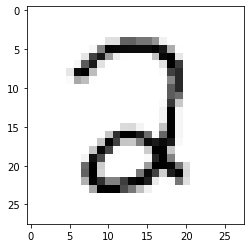

In [9]:
image_index = 7776 # You may select anything up to 60,000
print(train_labels[image_index]) 
plt.imshow(train_images[image_index], cmap='Greys')

## Filter data to get 3 and 8 out

In [10]:
train_filter = np.where((train_labels == 3 ) | (train_labels == 8))
test_filter = np.where((test_labels == 3) | (test_labels == 8))
X_train, y_train = train_images[train_filter], train_labels[train_filter]
X_test, y_test = test_images[test_filter], test_labels[test_filter]

We normalize the pizel values in the 0 to 1 range

In [11]:
X_train = X_train/255.
X_test = X_test/255.

And setup the labels as 1 (when the digit is 3) and 0 (when the digit is 8)

In [12]:
y_train = 1*(y_train==3)
y_test = 1*(y_test==3)

In [13]:
X_train.shape, X_test.shape

((11982, 28, 28), (1984, 28, 28))

We reshape the data to flatten the image pixels into a set of features or co-variates:

In [14]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_train.shape, X_test.shape

((11982, 784), (1984, 784))

In [15]:
#Impoting functions from 'Kudzu'
from kudzu.model import Model
from kudzu.train import Learner
from kudzu.optim import GD
from kudzu.data import Data, Sampler,Dataloader

from kudzu.callbacks import AccCallback
from kudzu.callbacks import ClfCallback

from kudzu.loss import MSE

from kudzu.layer import Sigmoid,Relu
from kudzu.layer import Affine

### Let us create a `Config` class, to store important parameters. 
This class essentially plays the role of a dictionary.

In [16]:
class Config:
    pass
config = Config()
config.lr = 0.001
config.num_epochs = 250
config.bs = 50

### Running Models with the Training data
Details about the network layers:
- A first affine layer has 784 inputs and does 100 affine transforms. These are followed by a Relu
- A second affine layer has 100 inputs from the 100 activations of the past layer, and does 100 affine transforms. These are followed by a Relu
- A third affine layer has 100 activations and does 2 affine transformations to create an embedding for visualization. There is no non-linearity here.
- A final "logistic regression" which has an affine transform from 2 inputs to 1 output, which is squeezed through a sigmoid.


In [17]:
data = Data(X_train, y_train.reshape(-1,1))
sampler = Sampler(data, config.bs, shuffle=True)

dl = Dataloader(data, sampler)

opt = GD(config.lr)
loss = MSE()

In [18]:
training_data_x = X_train
testing_data_x = X_test
training_data_y = y_train.reshape(-1,1)
testing_data_y = y_test.reshape(-1,1)

In [19]:
layers = [Affine("first", 784, 100), Relu("first"), Affine("second", 100, 100), Relu("second"), Affine("third", 100, 2), Affine("last", 2, 1), Sigmoid("last")]
model_nn = Model(layers)
model_lr = Model([Affine("logits", 784, 1), Sigmoid("sigmoid")])

xavier
xavier
xavier
xavier
xavier


In [20]:
nn_learner = Learner(loss, model_nn, opt, config.num_epochs)
acc_nn = ClfCallback(nn_learner, config.bs, training_data_x , testing_data_x, training_data_y, testing_data_y)
nn_learner.set_callbacks([acc_nn])

In [21]:
lr_learner = Learner(loss, model_lr, opt, config.num_epochs)
acc_lr = ClfCallback(lr_learner, config.bs, training_data_x , testing_data_x, training_data_y, testing_data_y)
lr_learner.set_callbacks([acc_lr])

In [22]:
nn_learner.train_loop(dl)

Epoch 0, Loss 0.237
Training Accuracy: 0.7296, Testing Accuracy: 0.7424



Epoch 10, Loss 0.1292
Training Accuracy: 0.9009, Testing Accuracy: 0.9078



Epoch 20, Loss 0.0716
Training Accuracy: 0.9279, Testing Accuracy: 0.9360



Epoch 30, Loss 0.0525
Training Accuracy: 0.9430, Testing Accuracy: 0.9546



Epoch 40, Loss 0.0436
Training Accuracy: 0.9519, Testing Accuracy: 0.9597



Epoch 50, Loss 0.0385
Training Accuracy: 0.9568, Testing Accuracy: 0.9657



Epoch 60, Loss 0.0351
Training Accuracy: 0.9599, Testing Accuracy: 0.9672



Epoch 70, Loss 0.0328
Training Accuracy: 0.9623, Testing Accuracy: 0.9682



Epoch 80, Loss 0.031
Training Accuracy: 0.9634, Testing Accuracy: 0.9682



Epoch 90, Loss 0.0295
Training Accuracy: 0.9651, Testing Accuracy: 0.9688



Epoch 100, Loss 0.0284
Training Accuracy: 0.9668, Testing Accuracy: 0.9698



Epoch 110, Loss 0.0273
Training Accuracy: 0.9676, Testing Accuracy: 0.9708



Epoch 120, Loss 0.0265
Training Accuracy: 0.9685, Testing Accuracy: 0.9713



Epoch 130, Loss 0.0257
Training Accuracy: 0.9693, Testing Accuracy: 0.9708



Epoch 140, Loss 0.025
Training Accuracy: 0.9702, Testing Accuracy: 0.9713



Epoch 150, Loss 0.0244
Training Accuracy: 0.9711, Testing Accuracy: 0.9718



Epoch 160, Loss 0.0238
Training Accuracy: 0.9716, Testing Accuracy: 0.9708



Epoch 170, Loss 0.0232
Training Accuracy: 0.9726, Testing Accuracy: 0.9718



Epoch 180, Loss 0.0227
Training Accuracy: 0.9731, Testing Accuracy: 0.9718



Epoch 190, Loss 0.0223
Training Accuracy: 0.9739, Testing Accuracy: 0.9713



Epoch 200, Loss 0.0218
Training Accuracy: 0.9745, Testing Accuracy: 0.9718



Epoch 210, Loss 0.0214
Training Accuracy: 0.9748, Testing Accuracy: 0.9718



Epoch 220, Loss 0.021
Training Accuracy: 0.9753, Testing Accuracy: 0.9718



Epoch 230, Loss 0.0206
Training Accuracy: 0.9759, Testing Accuracy: 0.9723



Epoch 240, Loss 0.0202
Training Accuracy: 0.9762, Testing Accuracy: 0.9733



0.025555382920694227

In [23]:
lr_learner.train_loop(dl)

Epoch 0, Loss 0.208
Training Accuracy: 0.7846, Testing Accuracy: 0.8125



Epoch 10, Loss 0.0988
Training Accuracy: 0.9109, Testing Accuracy: 0.9269



Epoch 20, Loss 0.0777
Training Accuracy: 0.9267, Testing Accuracy: 0.9415



Epoch 30, Loss 0.0676
Training Accuracy: 0.9338, Testing Accuracy: 0.9486



Epoch 40, Loss 0.0614
Training Accuracy: 0.9390, Testing Accuracy: 0.9531



Epoch 50, Loss 0.0571
Training Accuracy: 0.9419, Testing Accuracy: 0.9551



Epoch 60, Loss 0.0539
Training Accuracy: 0.9442, Testing Accuracy: 0.9561



Epoch 70, Loss 0.0514
Training Accuracy: 0.9472, Testing Accuracy: 0.9567



Epoch 80, Loss 0.0494
Training Accuracy: 0.9491, Testing Accuracy: 0.9592



Epoch 90, Loss 0.0477
Training Accuracy: 0.9504, Testing Accuracy: 0.9612



Epoch 100, Loss 0.0463
Training Accuracy: 0.9513, Testing Accuracy: 0.9617



Epoch 110, Loss 0.0451
Training Accuracy: 0.9528, Testing Accuracy: 0.9637



Epoch 120, Loss 0.044
Training Accuracy: 0.9544, Testing Accuracy: 0.9642



Epoch 130, Loss 0.0431
Training Accuracy: 0.9550, Testing Accuracy: 0.9632



Epoch 140, Loss 0.0422
Training Accuracy: 0.9553, Testing Accuracy: 0.9647



Epoch 150, Loss 0.0415
Training Accuracy: 0.9558, Testing Accuracy: 0.9657



Epoch 160, Loss 0.0408
Training Accuracy: 0.9568, Testing Accuracy: 0.9657



Epoch 170, Loss 0.0402
Training Accuracy: 0.9577, Testing Accuracy: 0.9657



Epoch 180, Loss 0.0396
Training Accuracy: 0.9579, Testing Accuracy: 0.9662



Epoch 190, Loss 0.0391
Training Accuracy: 0.9583, Testing Accuracy: 0.9667



Epoch 200, Loss 0.0386
Training Accuracy: 0.9584, Testing Accuracy: 0.9672



Epoch 210, Loss 0.0382
Training Accuracy: 0.9588, Testing Accuracy: 0.9672



Epoch 220, Loss 0.0378
Training Accuracy: 0.9593, Testing Accuracy: 0.9677



Epoch 230, Loss 0.0374
Training Accuracy: 0.9595, Testing Accuracy: 0.9677



Epoch 240, Loss 0.037
Training Accuracy: 0.9598, Testing Accuracy: 0.9677



0.05752133136505879

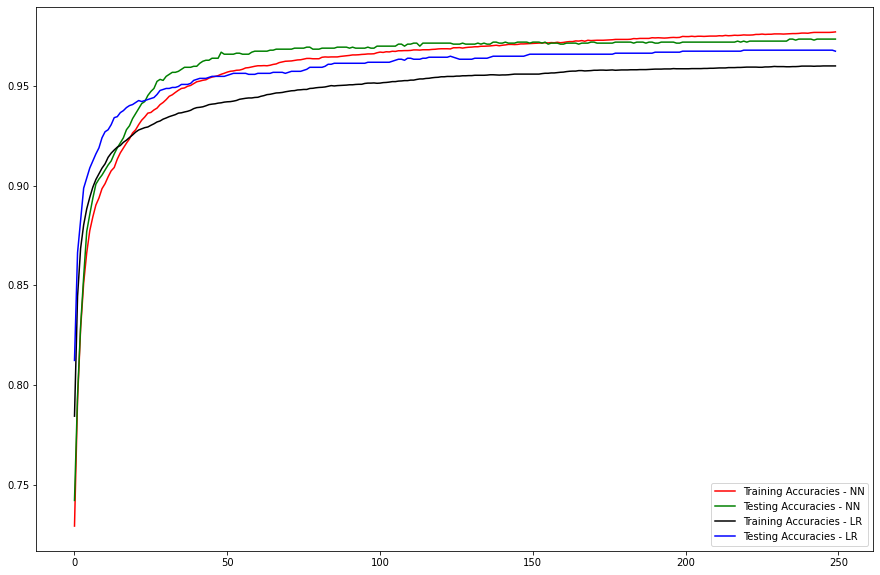

In [24]:
#comparing the results of NN and LR
plt.figure(figsize=(15,10))

# Neural Network plots
plt.plot(acc_nn.accuracies, 'r-', label = "Training Accuracies - NN")
plt.plot(acc_nn.test_accuracies, 'g-', label = "Testing Accuracies - NN")

# Logistic Regression plots
plt.plot(acc_lr.accuracies, 'k-', label = "Training Accuracies - LR")
plt.plot(acc_lr.test_accuracies, 'b-', label = "Testing Accuracies - LR")
plt.legend()

#### Plotting the outputs of this layer of the NN.


In [25]:
new_model = Model(layers[:-2])
testing_plot = new_model(testing_data_x)

Text(0.5, 1.0, 'Outputs')

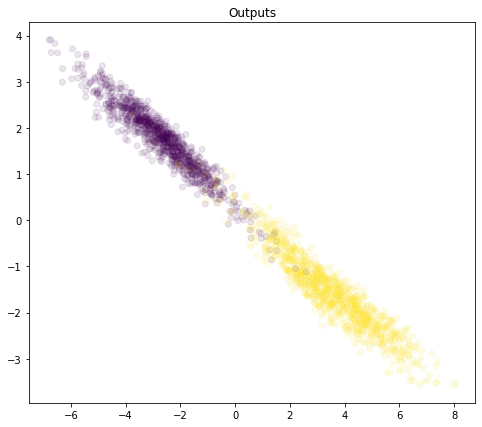

In [26]:
# Plotting the scatter plot of points and color coding by class
plt.figure(figsize=(8,7))
plt.scatter(testing_plot[:,0], testing_plot[:,1], alpha = 0.1, c = y_test.ravel());
plt.title('Outputs')

Probability contours

In [27]:
model_prob = Model(layers[-2:]) 

In [28]:
#creating the x and y ranges according to the above generated plot.
x_range = np.linspace(-4, 1, 100) 
y_range = np.linspace(-6, 6, 100) 
x_grid, y_grid = np.meshgrid(x_range, y_range) # x_grid and y_grig are of size 100 X 100

# converting x_grid and y_grid to continuous arrays
x_gridflat = np.ravel(x_grid)
y_gridflat = np.ravel(y_grid)

# The last layer of the current model takes two columns as input. Hence transpose of np.vstack() is required.
X = np.vstack((x_gridflat, y_gridflat)).T

prob_contour = model_prob(X).reshape(100,100) 

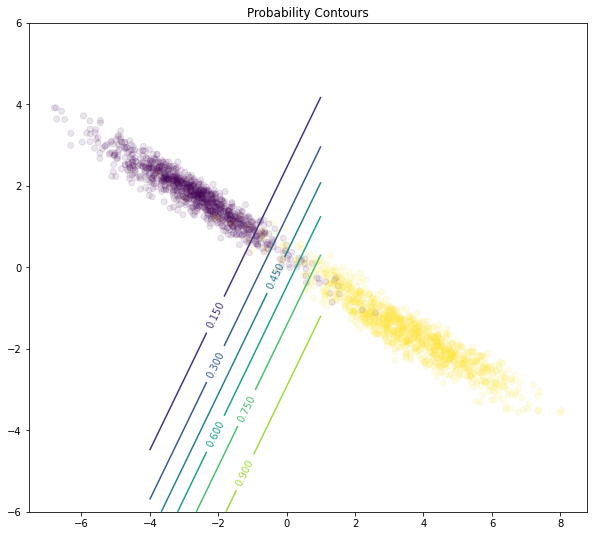

In [29]:
plt.figure(figsize=(10,9))
plt.scatter(testing_plot[:,0], testing_plot[:,1], alpha = 0.1, c = y_test.ravel())
contours = plt.contour(x_grid,y_grid,prob_contour)
plt.title('Probability Contours')
plt.clabel(contours, inline = True );